# Error Mitigation

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Surface Electron Spin Bath

In [15]:
register_config = [('NV', (0, 0, 0), 0, {})]

directory = os.getcwd()
filename = os.path.join( "baths", "surface_electrons_4")
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

xp, xm = q.sigmax().eigenstates()[1]
xp, xm = xp * xp.dag(), xm * xm.dag()
yp, ym = q.sigmay().eigenstates()[1]
yp, ym = yp * yp.dag(), ym * ym.dag()
zp, zm = q.sigmaz().eigenstates()[1]
zp, zm = zp * zp.dag(), zm * zm.dag()

kwargs = dict(suter_method=False, instant_pulses=True, env_approx_level='no_bath', verbose=False, thermal_bath=False)
env = Environment(register_config, bath_configs, **kwargs)
print(f'Environment approximation level: {env.env_approx_level}')

Environment approximation level: no_bath


In [16]:
%%time
pulse_seq = [80e-6]
t_list = np.linspace(0, 80e-6, 600)

hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))
start_time = time.time()
init_states = [xm, xp, ym, yp, zm, zp]
new_states_list = []
for init_state in init_states:
    env.old_register_states = [hada * init_state * hada]
    new_states_list.append( env.get_new_register_states(pulse_seq, t_list=t_list) )

for Bz in [0, 5e-6]:
    miri_list = []
    for new_states in new_states_list:
        detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-Bz) / (2*np.pi) - CONST["N_zz"] * CONST["m_N"]
        detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]
        
        new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)] 
          
        sigmax = [ q.expect(state, q.sigmax()) for state in new_states ]
        sigmay = [ q.expect(state, q.sigmay()) for state in new_states ]
        sigmaz = [ q.expect(state, q.sigmaz()) for state in new_states ]
        miri_list.append( [sigmax, sigmay, sigmaz] )
    
    miri_list = np.array(miri_list)
    print(f"Shape: {miri_list.shape}")
    
    save_directory = os.path.join(os.getcwd(), "export", filename)
    os.makedirs(save_directory, exist_ok=True)
    save_filename = f"{env.env_approx_level}_{int(Bz*1e6)}uT"
    save_loc = os.path.join(save_directory, save_filename)
    np.save(save_loc, miri_list)
    print(f'Saved as {save_loc}.npy')

Shape: (6, 3, 600)
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\baths\surface_electrons_4\no_bath_0uT.npy
Shape: (6, 3, 600)
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\baths\surface_electrons_4\no_bath_5uT.npy
CPU times: total: 828 ms
Wall time: 2.83 s


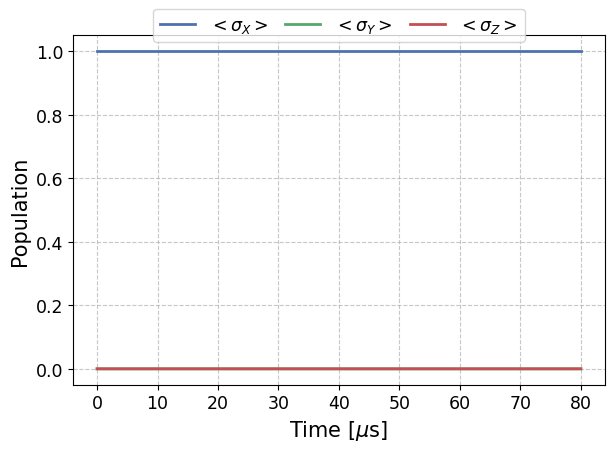

In [17]:
fig, ax = plt.subplots()

# save_directory = os.path.join(os.getcwd(), "export", "dominik_bath_small")
# save_filename = os.path.join('Suter', 'gCCE0_0uT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()